In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
from glob import glob
import PIL
from PIL import Image
import cv2
import os
import shutil
import random
import math
import tensorflow_datasets as tfds

In [2]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): 
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [3]:
def serialize_example(image,label):
    feature = {
        'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label':_bytes_feature(tf.io.serialize_tensor(label))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


In [4]:
!mkdir images

In [5]:
def tf_writer(op_path,filelist):
    classes=['yawn','no_yawn']
    with tf.io.TFRecordWriter(op_path) as writer:
                random.shuffle(filelist)
                for fn in filelist:
                    label = np.array([0,0],dtype='float64')
                    img = open(fn,'rb').read()
                    lab = fn.split('/')[-2]
                    lab = classes.index(lab)
                    label[lab] = 1.0
                    tf_example = serialize_example(img,label)
                    writer.write(tf_example)

In [6]:
def create_records(path):
    opr1 = "./images/train_rec"
    opr2 = "./images/val_rec"
    classes=['yawn','no_yawn']
    files_list = glob(path+'/no_yawn/*')
    files_list1 = glob(path+'/yawn/*')
    train_list = files_list[:math.ceil(len(files_list)*0.8)]  +  files_list1[:math.ceil(len(files_list1)*0.8)]
    val_list = files_list[math.ceil(len(files_list)*0.8):]  +  files_list1[math.ceil(len(files_list1)*0.8):]
    tf_writer(opr1,train_list)
    tf_writer(opr2,val_list)
        


In [7]:
create_records('../input/drowsiness-dataset/train')

2023-02-21 08:17:42.623585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 08:17:42.745607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 08:17:42.746485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 08:17:42.749125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
def parse_image(example):
    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[256,256])
    label = tf.io.parse_tensor(features['label'], out_type=tf.float64)
    label = tf.reshape(label,shape=(2,))
    return image,label


In [9]:
def read_dataset(filename,batchs):
    data = tf.data.TFRecordDataset(filename)
    ds = configure(data)
    return ds
    


In [10]:
def configure(data):
    data = data.map(parse_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    data = data.shuffle(500)
    data = data.batch(32,drop_remainder = True)
    data = data.repeat()
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return data

In [11]:
def use_records():
    train = read_dataset("./images/train_rec",32)
    val = read_dataset("./images/val_rec",32)
    return train,val
train_ds,val_ds= use_records()    

In [12]:
train_ds,val_ds

(<PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>)

In [13]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

2023-02-21 08:17:56.240536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


Label:  [1. 0.]


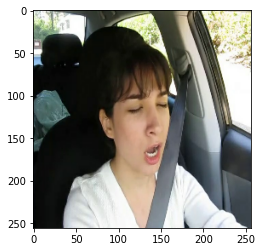

In [14]:
for image, label in val_ds.take(1):
  print("Label: ", label.numpy()[0])
  plt.imshow(image.numpy()[0].astype("uint8"))

In [15]:
# Label [0,1] => No Yawn  
# Label [1,0] =>  Yawn - Alert

In [16]:
cb = [tf.keras.callbacks.ModelCheckpoint("./first_model.h5",monitor='val_accuracy',save_best_only=True,mode='max')]

In [17]:
def build():
  model = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip(mode="horizontal"),
  tf.keras.layers.RandomRotation(0.2, fill_mode='reflect',interpolation='bilinear'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
 ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])
  return model  

In [18]:
model = build()

In [19]:
deep_model = model.fit(train_ds,steps_per_epoch=math.ceil(2320/32),validation_data=val_ds,validation_steps = math.ceil(580/32),epochs =30,callbacks=cb)


Epoch 1/30


2023-02-21 08:18:02.622727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - 18s 122ms/step - loss: 0.6629 - accuracy: 0.5826 - val_loss: 0.6163 - val_accuracy: 0.6151
Epoch 2/30
73/73 [==============================] - 10s 142ms/step - loss: 0.5780 - accuracy: 0.6678 - val_loss: 0.5933 - val_accuracy: 0.6464
Epoch 3/30
73/73 [==============================] - 9s 123ms/step - loss: 0.5610 - accuracy: 0.6772 - val_loss: 0.5955 - val_accuracy: 0.6316
Epoch 4/30
73/73 [==============================] - 8s 109ms/step - loss: 0.5683 - accuracy: 0.6764 - val_loss: 0.6234 - val_accuracy: 0.6299
Epoch 5/30
73/73 [==============================] - 8s 104ms/step - loss: 0.5472 - accuracy: 0.6922 - val_loss: 0.5845 - val_accuracy: 0.6283
Epoch 6/30
73/73 [==============================] - 7s 102ms/step - loss: 0.5271 - accuracy: 0.7085 - val_loss: 0.5700 - val_accuracy: 0.7138
Epoch 7/30
73/73 [==============================] - 9s 121ms/step - loss: 0.5061 - accuracy: 0.7359 - val_loss: 0.5337 - val_accuracy: 0.7336
Epoch 8/30
73/7

In [20]:
df = pd.DataFrame(deep_model.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.662941,0.582620,0.616281,0.615132
1,0.577972,0.667808,0.593305,0.646382
2,0.561044,0.677226,0.595543,0.631579
3,0.568342,0.676370,0.623448,0.629934
4,0.547239,0.692209,0.584532,0.628289
5,0.527111,0.708476,0.570038,0.713816
6,0.506115,0.735873,0.533684,0.733553
7,0.491119,0.743151,0.492794,0.758224
8,0.410167,0.819349,0.388278,0.850329
9,0.361042,0.842038,0.921120,0.657895


<AxesSubplot:>

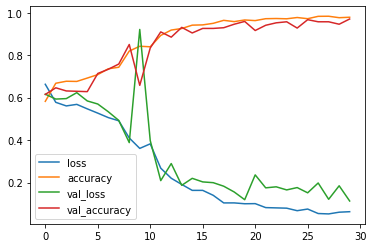

In [21]:
df.plot()

Prediction : Yawn


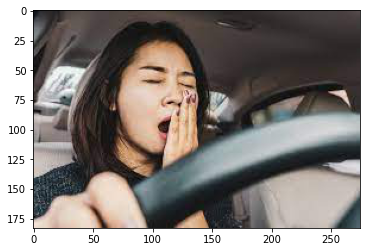

Prediction : Yawn


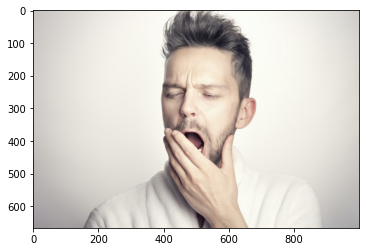

Prediction : Not Yawning


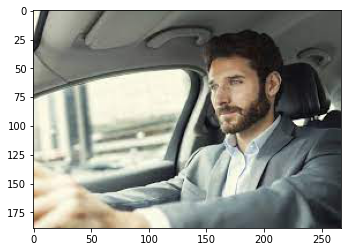

Prediction : Not Yawning


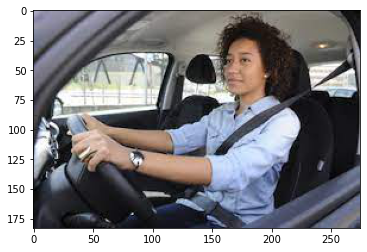

Prediction : Not Yawning


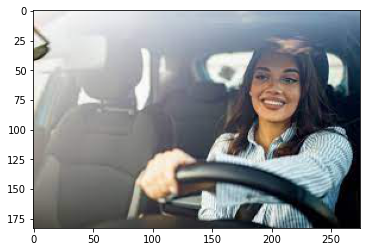

Prediction : Yawn


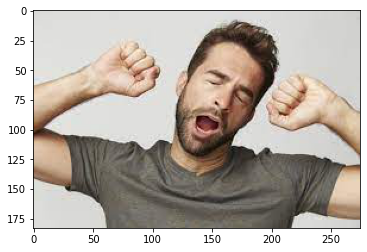

Prediction : Yawn


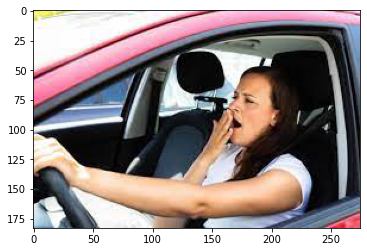

Prediction : Not Yawning


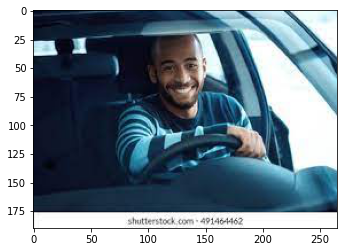

In [26]:
for i in glob("/kaggle/input/yawn-test-data/imgs/*"):
    im = plt.imread(i)
    plt.imshow(im)
    img = tf.expand_dims(im,axis = 0)
    if np.argmax(np.squeeze(np.round(model(img)))) == 0:
        print("Prediction : Yawn")
    else:
        print("Prediction : Not Yawning")
    plt.show()